<a href="https://colab.research.google.com/github/alaekichiaminecharko/CLT/blob/master/Projet_tweet_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet : Analyse des sentiments à partir de Tweet
Author :  KICHI Alae  

Date : 01 Janvier 2020

## Table des matières:

## Introduction

Natural Language Processing (NLP) autrement appelé en français **Traitement automatique du langage naturel** est une branche très importante du Machine Learning et donc de l’intelligence artificielle. Le NLP est la capacité d’un programme à comprendre le langage humain.

Prenons quelques exemples pratiques qu’on utilise tous les jours pour mieux comprendre :

- Les spams : toutes les boîtes mails utilisent un filtre antispam et cela fonctionne avec le filtrage bayésien en référence au théorème de Bayes qui est une technique statistique de détection de spams. Ces filtres vont “comprendre” le texte et trouver s’il y a des corrélations de mots qui indiquent un pourriel.
- Google Traduction : vous avez probablement tous utilisé ce système et leur technologie utilise de nombreux algorithmes dont du NLP. Ici, le défi n’est pas de traduire le mot, mais de garder le sens d’une phrase dans une autre langue.
- Le logiciel Siri créé par Apple ou Google Assistant utilise du NLP pour traduire du texte transcrit en du texte analysé afin de vous donner une réponse adaptée à votre demande.

Il est important de comprendre que pour avoir un algorithme qui marche avec du NLP, il faut un grand nombre de données afin d’éviter les biais. Il y a trois types d’ensembles de données :

- Ensemble de données entraînées (training set)
- Ensemble de données validées (validation set)
- Ensemble de données testées (testing set)

On forme avec l’aide du **set d’entraînement**, on ajuste les paramètres à l’aide du **set de validation**, pour ensuite tester les performances.

Dans l'étude que nous menons, nous allons traiter une base de données composée de Tweets afin d'analyser le sentiment des personnes écrivant ces tweets. Le but de cet étude est de réaliser un modèle perfomant pour classifier les tweets selon leur polarité.

- Ci-dessous le lien de la base de données utilisée:

http://help.sentiment140.com/for-students



## Importation et préparation des données

### Importation des bibliothèques

In [1]:
import sys
import warnings
import re
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


- NLTK :

NLTK est une plate-forme de pointe pour la construction de programmes Python destinés à travailler avec des données en langage humain. Elle fournit une suite de bibliothèques de traitement de texte pour la classification, la tokénisation, le balisage, l'analyse syntaxique et le raisonnement sémantique, des enveloppes pour les bibliothèques NLP de puissance industrielle.

### Importation de la base de données

In [0]:
data=pd.read_csv(r'training.1600000.processed.noemoticon.csv', encoding = 'latin',engine='python', header=None)

La base de données ne contient pas les noms des variables. Nous allons donner des noms à ces variables.

In [0]:
#data = data.drop(data.columns[0], axis=1)
data.columns=['polarity','id','tweet_date','query','username','tweet_text']

La base de données se compose de 6 variables:

- Polarity : la polarité du tweet (0 = négatif, 4 = positif)
- id : Identifiant du tweet
- tweet_date : La date du tweet
- query : la requête 
- username : Nom d'utilisateur
- tweet_text : Le texte du tweet

### Exploration des données :

In [0]:
data = data.drop(['id', 'tweet_date','query',  'username'], axis=1)

In [7]:
data.isnull().sum()

polarity      0
tweet_text    0
dtype: int64

La base de données ne contient pas des valeurs manquantes.

Nous remarquons que la variable **query** a une valeur unique. Nous gardons quand même cette variable car dans notre étude nous nous focalisons que sur la variable **polarity** et **tweet_text**.

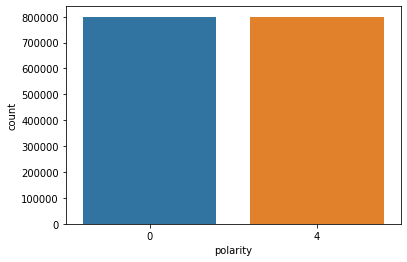

In [9]:


sns.countplot(x="polarity", data=data)

La base de données est bien équilibrée. Ceci est important afin de garantir de bons résultats de classification surtout pour l'approche du **SVM**.

### Le prétraitement des données :

Il est évidemment inintéressant de traiter les données telles quelles : nous n'apprenons rien. Il va alors falloir extraire de l'information de ces phrases en les transformants. Cependant il faut faire attention à plusieurs choses :

- On peut trouver des caractères qui n'ont pas leur place comme des symboles ou des mots mal extraits par exemple \x3c.
- Les majuscules peuvent être problématique car a != A. Par exemple, car != Car.
- Les accents ainsi que les signes de ponctuation peuvent également poser problème.
- Certains mots sont très présent : ils n'apportent peut-être aucune information.

Il va donc falloir transformer et nettoyer les données !

#### Suppression  des @names :

In [0]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text

data['clean_tweet'] = np.vectorize(remove_pattern)(data['tweet_text'], "@[\w]* | *RT*")

####  Suppression des liens http :

In [0]:
cleaned_tweets = []

for index, row in data.iterrows():
    words_without_links = [word for word in row.clean_tweet.split() if 'http' not in word]
    cleaned_tweets.append(' '.join(words_without_links))
    
data['clean_tweet'] = cleaned_tweets

#### Suppression des nombres

In [0]:
def clean_nombre(text): 
    nombre = '''0123456789'''

    for x in text.lower(): 
        if x in nombre: 
            text = text.replace(x, "") 
  
    return text

data['clean_tweet']=data['clean_tweet'].apply(clean_nombre)

#### Suppression des ponctuations

In [0]:
def Punctuation(string): 
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    for x in string.lower(): 
        if x in punctuations: 
            string = string.replace(x, "") 
  
    return string

data['clean_tweet']=data['clean_tweet'].apply(Punctuation)

####  Suppression des doublons :

In [14]:
data.drop_duplicates(subset=['clean_tweet'], keep=False)

,polarity,tweet_text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Awww thats a bummer You shoulda got David Car...
1,0,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
2,0,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball Managed to sav...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...
...,...,...,...
1599995,4,Just woke up. Having no school is the best fee...,Just woke up Having no school is the best feel...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...,TheWDBcom Very cool to hear old Walt intervie...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...,Are you ready for your MoJo Makeover Ask me fo...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...,Happy th Birthday to my boo of alll time Tupac...


#### Suppression des stopwords :

Un **stopword** est un mot très fréquent dans une langue et que l'on retrouve réguliérement dans des phrases, comme par exemple des conjonctions de coordination. La liste des stopword existant par langue est présente dans la bibliothèque **NLTK** : _ corpus.stopwords.words('langue').

Par exemple : En français, des mots vides évidents pourraient être « le », « la », « de », « du », « ce »…

In [15]:
stopwords = nltk.corpus.stopwords.words('english')
cleaned_tweets = []

for index, row in data.iterrows():
     
    words_without_stopwords = [word for word in row.clean_tweet.split() if not word in stopwords and '#' not in word.lower()]
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
data['clean_tweet'] = cleaned_tweets
data.shape

(1600000, 3)

####  Suppression des tweets vides :

In [0]:
data= data[data['clean_tweet']!='']

####  Réinitialisation des index :

In [0]:
data= data.reset_index(drop=True)

#### Tokénization de la base de données :

Tokenizer une phrase revient à la séparer en tokens, c'est-à-dire en mots ou symboles distincts. D'un texte on extrait un vecteur de tokens.

Par exemple : La phrase "**Il fait beau et, chaud**" devient le vecteur [ "Il", "fait", "beau", "et", ",", "chaud" ].

In [0]:
tokens = data['clean_tweet'].apply(lambda x: [w for w in nltk.word_tokenize(x)]).values

In [20]:
data.head(20)

,polarity,tweet_text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Awww thats bummer You shoulda got David Carr T...
1,0,is upset that he can't update his Facebook by ...,upset cant update Facebook texting might cry r...
2,0,@Kenichan I dived many times for the ball. Man...,I dived many times ball Managed save The rest ...
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving im mad I cant see
5,0,@Kwesidei not the whole crew,whole crew
6,0,Need a hug,Need hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,hey long time see Yesains bit bit LOL Im fine ...
8,0,@Tatiana_K nope they didn't have it,nope didnt
9,0,@twittera que me muera ?,que muera


#### Word Cloud

Le WordCloud est une technique permettant de montrer quels sont les mots les plus fréquents dans un texte donné.

In [0]:
import wordcloud
from wordcloud import WordCloud

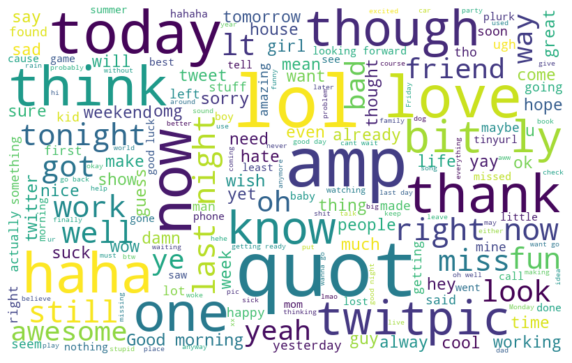

In [22]:
all_words = ' '.join([text for text in data['tweet_text']])
wordcloud = WordCloud(width=800,height=500,random_state=21,
                      max_font_size=110, background_color="white").generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

La figure ci-dessus montre quels sont les mots les plus fréquents dans toute la base de données.

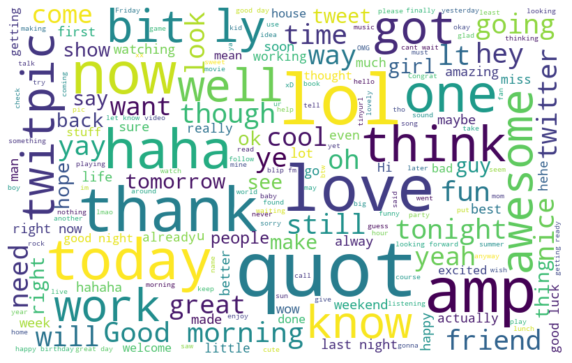

In [23]:
positive_words = ' '.join([text for text in data['tweet_text'][data['polarity']==4]])
wordcloud = WordCloud(width=800,height=500,random_state=21,
                      max_font_size=110, background_color="white").generate(positive_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

La figure ci-dessus montre quels sont les mots les plus fréquents dans le corpus des tweet positifs.

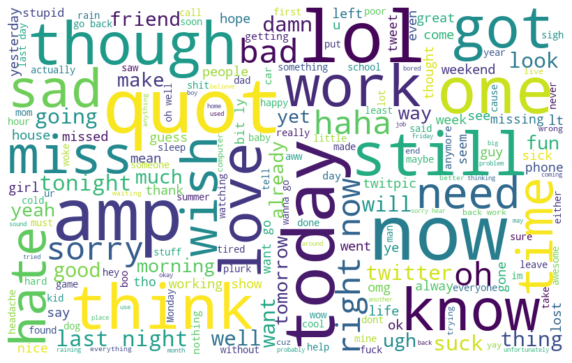

In [24]:
negative_words = ' '.join([text for text in data['tweet_text'][data['polarity']==0]])
wordcloud = WordCloud(width=800,height=500,random_state=21,
                      max_font_size=110, background_color="white").generate(negative_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

La figure ci-dessus montre quels sont les mots les plus fréquents dans le corpus des tweet negatifs.

## Construction des modèles

### Création de features naïfs

À partir des données textuelles, nous allons créer une nouvelle base de données avec des indicateurs statistiques comme **nb_mots**, **nb_unique**... afin de réaliser une analyse descriptive de nos données et ensuite appliquer un modèle de régression logistique que nous définissons un peu plus loin. 

Pour cela, nous utilisons la liste des mots tokenizer que nous avons implémenté plus haut.

In [0]:
import string

new_data = pd.DataFrame()

new_data['nb_mots'] = [len(w) for w in tokens]
new_data['nb_unique'] = [len(np.unique(w)) for w in tokens]
new_data['nb_phrases'] = data["tweet_text"].apply(lambda x: len(x.split('.')))
new_data['moyenne_mots'] = [np.mean([len(x) for x in w]) for w in tokens]
new_data["nb_ponctuation"] = data['tweet_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#### Visualisation des données 

In [26]:
new_data.head()

,nb_mots,nb_unique,nb_phrases,moyenne_mots,nb_ponctuation
0,11,11,4,4.181818,12
1,12,12,5,5.250000,6
2,11,11,2,4.090909,3
3,6,6,1,4.500000,0
4,6,6,4,3.500000,9


On définit une fonction pour vérifier si la base de données **new_data** contient des valeurs manquantes.

In [0]:
def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    #Affiche que les variables avec des na
    print (missing_data[(percent>0)],'\n' )
Missing_values(new_data)

Empty DataFrame
Columns: [Total, Pourcentage]
Index: [] 



On remarque qu'il existe des valeurs manquantes dans cette base de données. Nous allons procéder à leurs imputations.

In [0]:
# Imputer les valeurs manquantes
new_data.fillna(0, inplace = True)
Missing_values(new_data)

Empty DataFrame
Columns: [Total, Pourcentage]
Index: [] 



Nous avons imputer les valeurs manquantes en les remplaçant par 0.

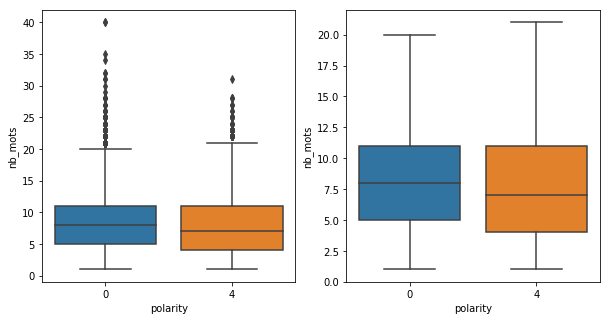

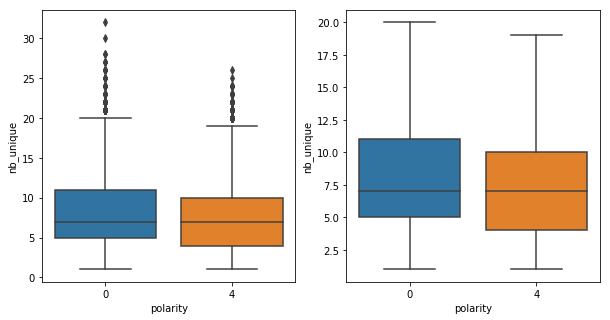

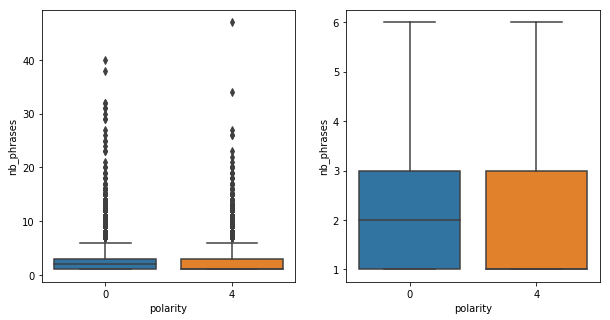

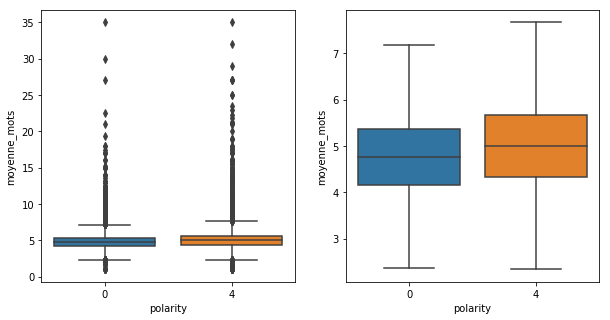

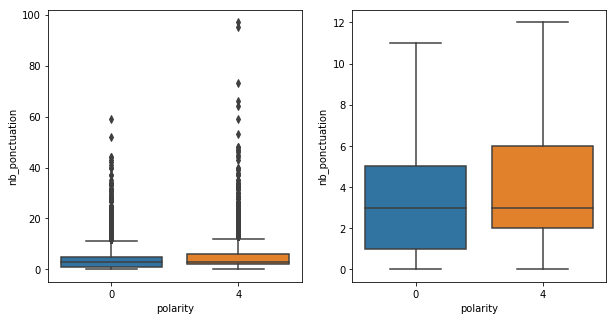

In [0]:
# Afficher le boxplot de la variable "polarity"
plt.rcParams['figure.figsize'] = (10,5)

for c in new_data.columns:
    plt.figure()
    plt.subplot(121)
    sns.boxplot(data['polarity'],new_data[c],orient = 'v',showfliers = True)
    
    plt.subplot(122)
    sns.boxplot(data['polarity'],new_data[c],orient = 'v',showfliers = False)

Nous avons affiché le boxplot de la variable **polarity** en prenant compte des valeurs aberrantes et en les supprimants.

Nous remarquons que la distribution des variables reste inchangée soit pour la polarité négative ou positive. 

#### Régression Logistique:

La régression logistique est un modèle de classification linéaire qui est le pendant de la régression linéaire , quand Y ne doit prendre que deux valeurs possibles (0 ou 1). Comme le modèle est linéaire, la fonction hypothèse pourra s’écrire comme suit : $$S(X^{(i)}) = \theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} + \theta_{3} x_{3}+....+ \theta_{n} x_{n}$$
avec :

- $X^{(i)}$ : une observation (que ce soit du Training Set ou du Test Set), cette variable est un vecteur contenant $x_{1}, x_{2},...,x_{n}$
- $x_{i}$ : est une variable prédictive (feature) qui servira dans le calcul du modèle prédictif
- $\theta_{i}$ : est un poids/paramètre de la fonction hypothèse. Ce sont ces $\theta_{i}$ qu’on cherche à calculer pour obtenir notre fonction de prédiction
- $\theta_{0}$ est une constante nommée le bias (biais)

On peut observer qu’on peut réécrire $\theta_{0}$ en : $\theta_{0}  x_{0}$ avec $x_{0} = 1$, cela nous permet de réécrire notre fonction $S(X)$ de façon plus compacte comme suit :

$$S(X)= \sum_{i=0}^{n + 1} (\theta_{i} x_{i})$$

On définit $X^{(i)}$ comme étant un vecteur de $x_{1}, x_{2},...,x_{n}$. Faisant la même chose pour les $\theta_{(i)}$ : soit grand théta $\Theta$ le vecteur contenant $\theta_{0}, \theta_{1},..., \theta_{n},$.

Notre fonction hypothèse peut- être vue comme le produit de deux vecteurs $\Theta$ et $X$ :

$$S(X) = \Theta X$$

On appelle cette fonction hypothèse : la fonction score. L’idée est de trouver des coefficients $\theta_{0}, \theta_{1}, …,\theta_{n}$ de sorte que :

$S(X^{(i)}) > 0$ quand la classe (étiquette) vaut 1
$S(X^{(i)}) < 0$ quand la classe (étiquette) vaut 0

La fonction score qu’on a obtenue intègre les différentes variables prédictives (les $x_{i}$). A cette fonction, on appliquera la fonction sigmoid (Sigmoid Function). Cette fonction produit des valeurs comprises entre 0 et 1.

Le résultat obtenu par la fonction sigmoid est interprété comme la probabilité que l’observation $X$ soit d’un label (étiquette) 1.

La fonction Logistique (autre nom pour la fonction Sigmoid), est définie comme suit

 $$Sigmoid(x) = \frac{1}{1 + e^x}$$

En appliquant cette fonction sigmoid sur notre fonction score, on obtient notre fonction hypothèse pour la régression logistique :

$$H (X) = Sigmoid (S(X)) = Sigmoid (\Theta X)$$

Ce qui donne :

 $$Sigmoid(\Theta X) = \frac{1}{1 + e^{\Theta X}}$$


In [27]:
cv = cross_val_score(LogisticRegression(),new_data,data['polarity'],scoring='accuracy',cv=3)
print ('Performance Logistic Regression : {} +/- {}'.format(cv.mean(),cv.std()))

Performance Logistic Regression : 0.5849656603054202 +/- 0.002189357797147015


Le score obtenu à travers cette approche est d'environ 58%. L'approche naïve que nous avons suivi n'est pas efficace pour prédire la polarité des tweet.

### L'approche: SVM

#### Définition du SVM 

Le principe de base des SVM consiste de ramener le problème de la discrimination à celui, linéaire, de la recherche d’un hyperplan optimal. Deux idées permettent d’atteindre cet objectif :
- On cherche l’hyperplan comme solution d’un problème d’optimisation sous-contraintes. La fonction à optimiser intègre un terme de qualité de prédiction et un terme de complexité du modèle. 
- Le passage à la recherche de surfaces séparatrices non linéaires est introduit en utilisant un noyau kernel qui code une transformation non lineaire des données.

Nous avons besoin de construire des vecteurs à partir des données textes. Pour cela, nous utilisons une méthode appelée Bag Of Words.

#### Définition du bag of words

Un modèle Bag Of Words, ou BoW, est un moyen d'extraire des caractéristiques d'un texte pour les utiliser dans la modélisation.

L'approche est très simple et flexible, et peut être utilisée de multiples façons pour extraire des caractéristiques de documents.

La représentation avec bags-of-words se déroule en trois étapes distinctes:

- 1 Tokenization de chaque document du corpus (chaque observation dans notre cas).
- 2 Construction du vocabulaire du corpus, on récupère tous les tokens existant.
- 3 On construit un vecteur pour chaque observation avec le nombre d'apparition de chaque mot du vocabulaire.

L'output de cet algorithme est une matrice de taille (nb observations, nb de mots unique du corpus). **CountVectorizer** est une implémentation de cette méthode, présente dans **sklearn**, qui effectue les trois étapes.

Par exemple: on dispose du corpus suivant ["La vie est douce", "La vie est tranquille et est belle"]

- 1 Tokenization : [[La,vie,est,douce],[La,vie, est, tranquille, et, est, belle]]
- 2 Vocabulary building : [La, vie, est, douce, belle, et, tranquille]
- 3 Encoding : [[1,1,1,1,0,0,0],[1,1,2,0,1,1]]

In [28]:
corpus = data.clean_tweet.values
vect = CountVectorizer()
data_vector = vect.fit_transform(corpus)

#indexation de la matrice
indexed_vector = hstack((np.array(range(0,data_vector.shape[0]))[:,None], data_vector))

from sklearn import svm
from sklearn.model_selection import train_test_split
train_data, test_data, train_target, test_target = train_test_split(indexed_vector, data['polarity'], 
                                                                    test_size=0.4, random_state=0)

clf = svm.SVC(gamma=0.01, C=100.,class_weight='balanced', kernel='linear')
clf.fit(train_data,train_target)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.01,
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [29]:
clf.score(test_data, test_target)

0.999982754917592

## 3ème Approche:

In [0]:
#Tokénization
tokenized_tweet = data['clean_tweet'].apply(lambda x: x.split())

In [31]:
#Lemmatization:
nltk.download('wordnet')
word_lemmatizer = nltk.WordNetLemmatizer()
lemmatized_tweet = tokenized_tweet.apply(lambda x: [word_lemmatizer.lemmatize(i, pos= 'v') for i in x])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [32]:
print(data['clean_tweet'][0])
print(tokenized_tweet[0])
print(tokens[0])

Awww thats bummer You shoulda got David Carr Third Day D
['Awww', 'thats', 'bummer', 'You', 'shoulda', 'got', 'David', 'Carr', 'Third', 'Day', 'D']
['Awww', 'thats', 'bummer', 'You', 'shoulda', 'got', 'David', 'Carr', 'Third', 'Day', 'D']


In [0]:
#stemming:
word_stemmer = nltk.PorterStemmer()
stemmed_tweet=lemmatized_tweet.apply(lambda x: [word_stemmer.stem(i) for i in x])

In [0]:
## join the stemmed/lemmatized words in a sentence:
reduced_tweet=[]
for i, words in enumerate(stemmed_tweet):
    reduced_tweet.append(' '.join(words))

data['clean_tweet'] = reduced_tweet

In [36]:
print(data['clean_tweet'][0])

awww that bummer you shoulda get david carr third day D


In [37]:
#Count_Vectorizer:
corpus = data.clean_tweet.values
vect = CountVectorizer()
data_bags = vect.fit_transform(corpus)
print ("Représentation des données avec bag of words {} ".format(repr(data_bags)))

cv_bag = cross_val_score(LogisticRegression(),data_bags,data['polarity'],scoring='accuracy',cv=3)
print ('Performance Logistic Regression {} +/- {}'.format(cv_bag.mean(),cv_bag.std()) )

Représentation des données avec bag of words <1594656x406684 sparse matrix of type '<class 'numpy.int64'>'
	with 11594057 stored elements in Compressed Sparse Row format> 
Performance Logistic Regression 0.7700457026468405 +/- 0.002828432959531763


In [38]:
#TF-IDF methode basée sur term frequency 

corpus = data.clean_tweet.values
vect = TfidfVectorizer()
data_tfidf = vect.fit_transform(corpus)
print ("Représentation des données avec bag of words {}".format(repr(data_tfidf)))

cv_tfidf = cross_val_score(LogisticRegression(),data_tfidf,data['polarity'],scoring='accuracy',cv=3)
print ('Performance Logistic Regression {} +/- {}'.format(cv_tfidf.mean(),cv_tfidf.std()) )

Représentation des données avec bag of words <1594656x406684 sparse matrix of type '<class 'numpy.float64'>'
	with 11594057 stored elements in Compressed Sparse Row format>
Performance Logistic Regression 0.7728343918688418 +/- 0.002744633930765254


We can see that the best accuracy i had is 77 percent.
I used differents méthodes of machine learning to handle this tweet sentimental problem, i didn't work on optimazing the models for some reasons but the principal goal behind this project is to see how this algorithms work on such type of  problems that demande a specific treatement from preparing the text to tokenizing it and transform the words to numbers before starting to apply any machine algorithm. The NLP itself is a huge field where we can explore and try to solve its problems with classic machine learning algorithms such logistic regression, svm.But We can get much  better results if we apply deep learning models such CNN.  